
Improve the performance of the model using one (or both) of the proposed techniques:

1) Hyperparameter tuning

Use one of the keras tuner hyperparameter search methods in order to improve the performance of the network. Implement it in such a way, that also the number of layers of the network (the architecture) is a hyperparameter.

Things to consider are:
- To add additional set of Conv2D/MaxPooling/Dropout layers with more neurons
- To use twin Conv2D layers of the same number of neurons:
```
Conv2D
Conv2D
MaxPooling
Dropout
```
- To experiment with different optimizers

This link will be usefull: https://keras.io/guides/keras_tuner/getting_started/
And this: https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

2) Data augumentation

Further reading on data augmentation:
https://www.datacamp.com/tutorial/complete-guide-data-augmentation

Provide a link to your colab notebook by mail (grega@agh.edu.pl) by 16th May 2023. Please provide your name in your notebook file name.

Competition: The highest accuracy on test set wins!

This homework is compulsory.

In [87]:
import platform
import sys

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np

# define Seaborn color palette to use
import pandas as pd
import tensorflow as tf
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from tensorflow import keras

# from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras.utils import to_categorical

In [88]:
import logging

from rich.logging import RichHandler

FORMAT = "%(message)s"
logging.basicConfig(
    level="NOTSET", format=FORMAT, datefmt="[%X]", handlers=[RichHandler()]
)

logger = logging.getLogger("rich")

In [89]:
VERBOSE_LOGGING = True

In [90]:
v = platform.python_version_tuple()
if float(v[1]) < 10:
    raise Exception("MUST USE Python 3.10 to use MATCH expression!")

# warnings.filterwarnings("ignore", "is_categorical_dtype")
# warnings.filterwarnings("ignore", "use_inf_as_na")
np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_colwidth = 1000

# LIBRARY CODE Start

In [91]:
from collections import namedtuple
from typing import NamedTuple

TupleD = namedtuple("TupleD", "x y")
MLData = namedtuple("MLData", "train_data valid_data")


# Hyperparameters!
class HyperParameters(NamedTuple):
    droputs: float
    output_layers: int
    epochs: int
    batch_size: int
    input_dim: int
    optimizer: str
    loss_f: str
    output_layer_activation_f: str
    validation_split: float

# LIBRARY CODE End

In [156]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
num_classes = len(class_names)

# https://www.tensorflow.org/datasets/catalog/cifar10

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

_one_train_data = TupleD(X_train, y_train)
_one_valid_data = TupleD(X_test, y_test)
one_mld_data = MLData(_one_train_data, _one_valid_data)

In [161]:
def build_base_model(hyperparams, name, hp):
    model = keras.Sequential()
    model.add(Input((hyperparams.input_dim)))

    _l_count = hp.Int("layer_count", min_value=2, max_value=5)
    # Init!
    for i, x in enumerate(range(_l_count)):
        _filters = hp.Int(f"filters_{i} ", min_value=32, max_value=224, step=32)
        model.add(Conv2D(_filters, (3, 3), activation="relu", padding="same"))
        model.add(MaxPooling2D(2, 2))
        model.add(Dropout(hyperparams.droputs))

    model.add(Flatten())
    last_dense_i = hp.Int("last_dense_i", min_value=32, max_value=224, step=32)

    model.add(Dense(last_dense_i, activation="relu"))
    model.add(Dropout(hyperparams.droputs))
    model.add(
        Dense(
            hyperparams.output_layers, activation=hyperparams.output_layer_activation_f
        )
    )
    lr_min, lr_max = 1e-4, 1e-1
    lr = hp.Float(
        "learning_rate",
        min_value=lr_min,
        max_value=lr_max,
    )
    optimizer_ss = [
        "adam",
        "SGD",
        "adamw",
        "adadelta",
        "adagrad",
        "adamax",
        "adafactor",
        "nadam",
        "lion",
    ]

    optimizer = hp.Choice("optimizer", optimizer_ss)
    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer == "adamw":
        optimizer = tf.keras.optimizers.Adamw(learning_rate=lr)
    elif optimizer == "adadelta":
        optimizer = tf.keras.optimizers.Adadelta(learning_rate=lr)
    elif optimizer == "adagrad":
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr)
    elif optimizer == "adamax":
        optimizer = tf.keras.optimizers.Adamax(learning_rate=lr)
    elif optimizer == "adafactor":
        optimizer = tf.keras.optimizers.Adafactor(learning_rate=lr)
    elif optimizer == "nadam":
        optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
    elif optimizer == "lion":
        optimizer = tf.keras.optimizers.Lion(learning_rate=lr)
    else:
        logger.error(f"NOT FOUND OPTIMIZER! {optimizer}")

    model.compile(optimizer=optimizer, loss=hyperparams.loss_f, metrics=["accuracy"])
    return model

In [167]:
hyperparams_one = HyperParameters(
    droputs=0.2,  # From RandomSearch previous
    output_layers=10,
    epochs=20,
    batch_size=32,
    input_dim=(32, 32, 3),
    optimizer="adam",
    loss_f="categorical_crossentropy",
    output_layer_activation_f="softmax",  # From RandomSearch previous
    validation_split=0.2,
)
model_name = "BaseModel"

In [168]:
def build_model_wrapper(hp):
    return build_base_model(hyperparams_one, model_name, hp)

In [ ]:
tuner = kt.RandomSearch(
    build_model_wrapper,
    objective="val_accuracy",
    directory="keras_tuner",
    project_name="ex_9",
    overwrite=True,
    executions_per_trial=1,
    seed=42,
    max_trials=10,
)

tensorboard_logs = keras.callbacks.TensorBoard("/tmp/tb_logs_random")
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
tuner.search(
    one_mld_data.train_data.x,
    one_mld_data.train_data.y,
    epochs=hyperparams_one.epochs,
    validation_split=hyperparams_one.validation_split,
    batch_size=hyperparams_one.batch_size,
    callbacks=[stop_early, tensorboard_logs],
)

Trial 2 Complete [00h 10m 41s]
val_accuracy: 0.10220000147819519

Best val_accuracy So Far: 0.6050999760627747
Total elapsed time: 00h 20m 41s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
5                 |4                 |layer_count
32                |32                |filters_0 
160               |96                |filters_1 
64                |64                |last_dense_i
0.03085           |0.088838          |learning_rate
adagrad           |adadelta          |optimizer
224               |32                |filters_2 
128               |32                |filters_3 

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.1766 - loss: 2.1624 - val_accuracy: 0.3504 - val_loss: 1.7270
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 66s 53ms/step - accuracy: 0.3443 - loss: 1.7435 - val_accuracy: 0.4721 - val_loss: 1.4709
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 69s 55ms/step - accuracy: 0.4492 - loss: 1.4952 - val_accuracy: 0.5260 - 

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    one_mld_data.train_data.x,
    one_mld_data.train_data.y,
    epochs=hyperparams_one.epochs,
    batch_size=hyperparams_one.batch_size,
)
test_loss, test_acc = model.evaluate(
    one_mld_data.valid_data.x, one_mld_data.valid_data.y, verbose=2
)
print(test_acc)

In [166]:
tuner.results_summary(num_trials=3)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Results summary
Results in my_dir/intro_to_kt
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
layer_count: 2
filters_0 : 128
filters_1 : 192
last_dense_i: 64
learning_rate: 0.07917344100255046
optimizer: SGD
filters_2 : 96
filters_3 : 32
filters_4 : 64
Score: 0.4625000059604645

Trial 06 summary
Hyperparameters:
layer_count: 2
filters_0 : 96
filters_1 : 224
last_dense_i: 128
learning_rate: 0.07604013168314647
optimizer: adadelta
filters_2 : 64
filters_3 : 96
filters_4 : 96
Score: 0.4124000072479248

Trial 02 summary
Hyperparameters:
layer_count: 5
filters_0 : 32
filters_1 : 160
last_dense_i: 64
learning_rate: 0.03084989479790436
optimizer: adagrad
filters_2 : 224
filters_3 : 128
filters_4 : 32
Score: 0.30959999561309814


In [ ]:
model.summary()

In [55]:
%reload_ext tensorboard
%tensorboard --logdir /tmp/my_dir

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Classification report: 
               precision    recall  f1-score   support

           0       0.72      0.81      0.77      1000
           1       0.83      0.87      0.85      1000
           2       0.62      0.63      0.63      1000
           3       0.57      0.48      0.53      1000
           4       0.65      0.70      0.67      1000
           5       0.68      0.55      0.61      1000
           6       0.79      0.78      0.78      1000
           7       0.76      0.79      0.77      1000
           8       0.78      0.88      0.83      1000
           9       0.84      0.79      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.72     10000
weighted avg       0.73      0.73      0.72     10000



[13:57:39] DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f98d8722b70>               ]8;id=500988;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/colorbar.py\colorbar.py]8;;\:]8;id=566069;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/colorbar.py#859\859]8;;\

/tmp/ipykernel_5734/3376301965.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


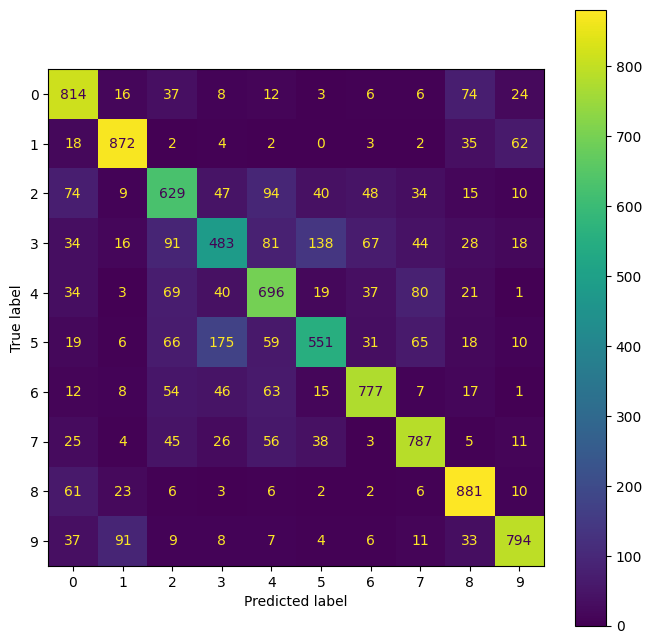

In [129]:
# classification report and confusion matrix
y_test_pred = np.argmax(model.predict(one_mld_data.valid_data.x), axis=1)
y_test_decoded = np.argmax(one_mld_data.valid_data.y, axis=1)
print(f"Classification report: \n {classification_report(y_test_decoded, y_test_pred)}")

cm = confusion_matrix(y_test_decoded, y_test_pred)

cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(8, 8))
cmp.plot(ax=ax)
fig.show()